In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import wandb
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.data.visium as visium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [5]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [6]:
run_dir = '/data/estorrs/mushroom/data/projects/xenium_grant'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-25943/config.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config.yaml']

In [7]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)', 'CD45(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}
# channel_mapping = None

In [8]:
mushroom_config = {
#     'sections': config,
    'sae_kwargs': {
        'size': 8,
        'patch_size': 1,
        'encoder_dim': 256,
        'num_clusters': (8, 4, 2,),
        'dtype_to_decoder_dims': {'multiplex': (256, 128, 64,), 'visium': (256, 512, 1024 * 2,), 'xenium': (256, 256, 256,)},
        'recon_scaler': 1.,
        'neigh_scaler': .0,
        'codebook_dim': 64,
    },
    'trainer_kwargs': {
        'input_ppm': 0.4705882352941177,
        'target_ppm': .01, # 100 microns per tile
        'contrast_pct': None,
        'pct_expression': .02,
        'batch_size': 64,
        'num_workers': 1,
        'devices': 1,
        'accelerator': 'gpu',
        'enable_checkpointing': True,
        'max_epochs': 10,
        'steps_per_epoch': 200,
        'channel_mapping': channel_mapping,
        'lr': 1e-4,
        'save_every': 1,
        'save_dir': './',
        'log_dir': './',
        'log_every_n_steps': 10,
#         'logger_project': 'model_testing_S18-9906',
        'logger_channel': 'CD45',
        'logger_type': 'wandb'
    },
}

In [9]:
config_fp = '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/testing/mushroom/integrated_{case}_v1/outputs')
save_dir = os.path.join(out_dir, 'chkpts')
log_dir = os.path.join(out_dir, 'logs')

Path(save_dir).mkdir(parents=True, exist_ok=True)

config = yaml.safe_load(open(config_fp))

In [10]:
config

[{'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s0_xenium.h5ad'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 5},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s2_xenium.h5ad'}],
  'id': 's2',
  'position': 35},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s3_multiplex.ome.tiff'}],
  'id': 's3',
  'position': 40},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s4_xenium.h5ad'}],
  'id': 's4',
  'position': 75},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s5_multiple

In [11]:
mushroom_config['sections'] = config
mushroom_config['trainer_kwargs']['logger_project'] = f'model_testing_integrated_{case}'
mushroom_config['trainer_kwargs']['save_dir'] = save_dir
mushroom_config['trainer_kwargs']['log_dir'] = log_dir

In [12]:
yaml.safe_dump(
    mushroom_config,
    open(os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'mushroom_config.yaml'), 'w')
)

In [13]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:starting multiplex processing
INFO:root:using 24 channels
INFO:root:4 sections detected: ['s1', 's3', 's5', 's7']
INFO:root:processing sections
INFO:root:generating image data for section s1
INFO:root:generating image data for section s3
INFO:root:generating image data for section s5
INFO:root:generating image data for section s7
INFO:root:starting xenium processing
INFO:root:using 377 channels
INFO:root:4 sections detected: ['s0', 's2', 's4', 's6']
INFO:root:processing sections
INFO:root:generating image data for section s0
INFO:root:generating image data for section s2
INFO:root:generating image data for section s4
INFO:root:generating image data for section s6
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 8 sections detected: [('s0', 'xenium'), ('s1', 'multiplex'), ('s2', 'xenium'), ('s3', 'multiplex'), ('s4', 'xenium'), ('s5', 'multiplex'), ('s6', 'xenium'), ('s7', 'multiplex')]
INFO:root:creating data loaders
INFO:root:cr

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
%%time
batch = next(iter(mushroom.train_dl))

CPU times: user 718 µs, sys: 81.9 ms, total: 82.7 ms
Wall time: 653 ms


In [15]:
batch.keys()

dict_keys(['tiles', 'slides', 'dtypes', 'pairs', 'is_anchor'])

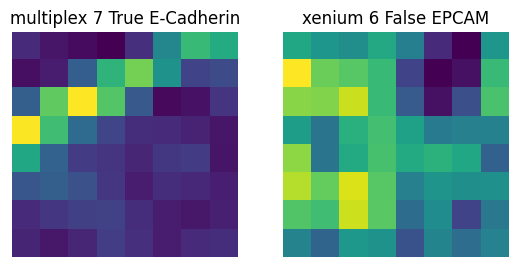

In [16]:
idx = 0
mushroom.train_dl.dataset.display_batch(
    batch, idx, mushroom.learner_data.dtype_to_channels,
    display_channels={'xenium': 'EPCAM', 'multiplex': 'E-Cadherin'}
)

In [17]:
device = mushroom.model.device
with torch.no_grad():
    tiles, slides, dtypes = batch['tiles'], batch['slides'], batch['dtypes']
    pairs, is_anchor = batch['pairs'], batch['is_anchor']
    
    tiles, slides, dtypes = [x.to(device) for x in tiles], [x.to(device) for x in slides], [x.to(device) for x in dtypes]
    pairs, is_anchor = [x.to(device) for x in pairs], [x.to(device) for x in is_anchor]
    losses, outputs = mushroom.model.sae(tiles, slides, dtypes, pairs=pairs, is_anchor=is_anchor)

In [18]:
losses

{'neigh_loss_level_0': tensor(1.9891),
 'recon_loss_0_multiplex': tensor(1.4664),
 'recon_loss_0_xenium': tensor(0.6451),
 'neigh_loss_level_1': tensor(1.2364),
 'recon_loss_1_multiplex': tensor(1.4666),
 'recon_loss_1_xenium': tensor(0.6451),
 'neigh_loss_level_2': tensor(0.6244),
 'recon_loss_2_multiplex': tensor(1.4671),
 'recon_loss_2_xenium': tensor(0.6450),
 'recon_loss': tensor(6.3352),
 'neigh_loss': tensor(3.8499),
 'overall_loss': tensor(6.3352)}

In [19]:
outputs.keys()

dict_keys(['encoded_tokens_prequant', 'level_to_encoded', 'cluster_probs', 'clusters', 'dtype_to_true_pixels', 'dtype_to_pred_pixels'])

In [20]:
for level in outputs['cluster_probs']: print(level.shape)

torch.Size([128, 64, 8])
torch.Size([128, 64, 4])
torch.Size([128, 64, 2])


In [21]:
for level in outputs['clusters']: print(level.shape)

torch.Size([128, 64])
torch.Size([128, 64])
torch.Size([128, 64])


In [22]:
for level in outputs['clusters']: print(level.unique())

tensor([0, 1, 2, 3, 4, 5, 6, 7])
tensor([0, 1, 2, 3])
tensor([0, 1])


In [23]:
for level in outputs['level_to_encoded']: print(len(level.sum(-1).unique()))

8
32
64


In [24]:
outputs['dtype_to_true_pixels']['multiplex'].shape

torch.Size([64, 64, 24])

In [25]:
outputs['dtype_to_true_pixels']['xenium'].shape

torch.Size([64, 64, 377])

In [26]:
outputs['dtype_to_pred_pixels']['multiplex'].shape

torch.Size([3, 64, 64, 24])

In [27]:
outputs['dtype_to_pred_pixels']['xenium'].shape

torch.Size([3, 64, 64, 377])

In [28]:
mushroom.train()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/testing/mushroom/integrated_S18-9906_v1/outputs/chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 10.3 M
------------------------------
10.3 M    Trainable params
0         Non-trainable params
10.3 M    Total params
41.146    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=10` reached.


In [51]:
mushroom.embed_sections()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

In [85]:
# mask = mushroom.agg_clusters[1]==0
mask = mushroom.clusters[1] == 2
labels = np.unique(mushroom.clusters[2][mask])

mask.shape, labels.shape, labels

((8, 188, 180), (2,), array([4, 5]))

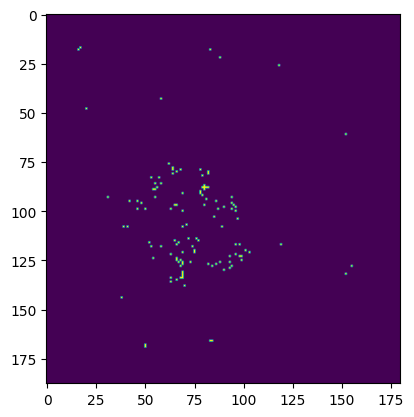

In [86]:
plt.imshow(mask[0])

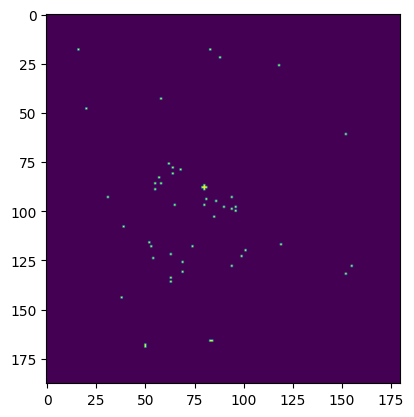

In [88]:
plt.imshow(mushroom.clusters[2][0]==5)

In [33]:
x1 = mushroom.clusters[0]
x2 = mushroom.clusters[1]
x1.shape, x2.shape

((8, 188, 180), (8, 188, 180))

In [ ]:
def smoosh(labeleds):
    

In [35]:
def smoosh(*args):
    new = ''
    for a in args:
        new += str(a)
    return int(new)

In [50]:
smooshed = np.vectorize(smoosh)(*mushroom.clusters)
smooshed = utils.relabel(torch.tensor(smooshed)).numpy()

In [51]:
smooshed.shape

(8, 188, 180)

In [53]:
len(np.unique(smooshed))

30

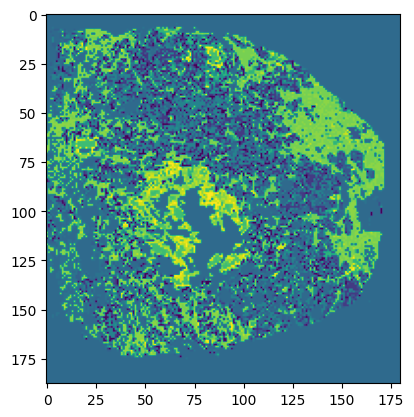

In [54]:
plt.imshow(smooshed[0])

In [45]:
vfunc(x1, x2)

array([[[22, 22, 22, ..., 22, 22, 22],
        [22, 22, 22, ..., 22, 22, 22],
        [22, 22, 22, ..., 22, 22, 22],
        ...,
        [22, 22, 22, ..., 22, 22, 22],
        [22, 22, 22, ..., 22, 22, 22],
        [22, 22, 22, ..., 22, 22, 22]],

       [[22, 22, 22, ..., 22, 22, 22],
        [22, 22, 22, ..., 22, 22, 22],
        [22, 22, 22, ..., 22, 22, 22],
        ...,
        [22, 22, 22, ..., 22, 22, 22],
        [22, 22, 22, ..., 22, 22, 22],
        [22, 22, 22, ..., 22, 22, 22]],

       [[22, 22, 22, ..., 22, 22, 22],
        [22, 22, 22, ..., 22, 22, 22],
        [22, 22, 22, ..., 22, 22, 22],
        ...,
        [22, 62, 22, ..., 22, 22, 22],
        [22, 22, 62, ..., 22, 22, 22],
        [22, 22, 22, ..., 22, 22, 22]],

       ...,

       [[22, 22, 22, ..., 22, 22, 22],
        [22, 22, 22, ..., 22, 22, 22],
        [22, 22, 22, ..., 22, 22, 22],
        ...,
        [22, 22, 22, ..., 22, 22, 22],
        [22, 22, 22, ..., 22, 22, 22],
        [22, 22, 22, ..., 22, 22

In [34]:
x1 + x2

array([[[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]],

       [[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]],

       [[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [2, 6, 2, ..., 2, 2, 2],
        [2, 2, 6, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]],

       ...,

       [[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]],

       [[2, 2, 2, ..., 2, 2, 2],
        [6, 6, 6, ..., 2, 2, 2],
        [6, 6, 1, ..., 2, 2, 2],
        ...,
        [2, 2, 2, ..., 

In [29]:
1

1

In [124]:
mushroom.model.learner_data.

['multiplex', 'xenium']

In [141]:
outputs = []
pl_module = mushroom.model
with torch.no_grad():
    for batch in mushroom.inference_dl:
        tiles, slides, dtypes = batch['tiles'], batch['slides'], batch['dtypes']
        tiles = [x.to(pl_module.device) for x in tiles]
        slides = [x.to(pl_module.device) for x in slides]
        dtypes = [x.to(pl_module.device) for x in dtypes]
        outs = pl_module.forward(tiles, slides, dtypes)
        outputs.append(outs)

In [146]:
out = mushroom.model.format_prediction_outputs(outputs)

In [147]:
out['clusters'][0].shape

torch.Size([8, 188, 180])

In [148]:
out['cluster_probs'][0].shape

torch.Size([8, 188, 180, 8])

In [150]:
out['predicted_pixels'][0][0].shape

torch.Size([188, 180, 377])

In [152]:
out['true_pixels'][0].shape

torch.Size([188, 180, 377])

In [135]:
flat = mushroom.model._flatten_outputs(outputs)

In [122]:
x = rearrange(flat['encoded_tokens_prequant'][:, 2:], 'b (h w) c -> b h w c', h=8, w=8)
out = mushroom.model.learner_data.inference_ds.section_from_tiles(
                x, 0)

In [123]:
out.shape

torch.Size([256, 188, 180])

In [136]:
# x = rearrange(flat['pred_pixels_0'], 'b (h w) c -> b h w c', h=8, w=8)
out = mushroom.model.learner_data.inference_ds.section_from_tiles(
                flat['pred_pixels_0'], 0)

In [137]:
out.shape

torch.Size([188, 180, 377])

In [131]:
flat['pred_pixels_0'][0].shape

torch.Size([3, 64, 377])

In [133]:
flat['true_pixels'][0].shape

torch.Size([64, 377])

In [64]:
for k, v in flat.items():
    print(k, v.shape)

encoded_tokens_prequant torch.Size([16920, 66, 256])
level_to_encoded_0 torch.Size([16920, 64, 64])
level_to_encoded_1 torch.Size([16920, 64, 64])
level_to_encoded_2 torch.Size([16920, 64, 64])
cluster_probs_0 torch.Size([16920, 64, 8])
cluster_probs_1 torch.Size([16920, 64, 4])
cluster_probs_2 torch.Size([16920, 64, 2])
clusters_0 torch.Size([16920, 64])
clusters_1 torch.Size([16920, 64])
clusters_2 torch.Size([16920, 64])
dtype_to_true_pixels_multiplex torch.Size([8460, 64, 24])
dtype_to_true_pixels_xenium torch.Size([8460, 64, 377])
dtype_to_pred_pixels_multiplex torch.Size([3, 8460, 64, 24])
dtype_to_pred_pixels_xenium torch.Size([3, 8460, 64, 377])


In [63]:
flat['dtype_to_pred_pixels_multiplex'].shape

torch.Size([3, 8460, 64, 24])

In [33]:
outputs[0]['outputs'].keys()

dict_keys(['encoded_tokens_prequant', 'level_to_encoded', 'cluster_probs', 'clusters', 'dtype_to_true_pixels', 'dtype_to_pred_pixels'])

In [41]:
outputs[0]['outputs']['encoded_tokens_prequant'].shape

torch.Size([64, 66, 256])

In [42]:
outputs[0]['outputs']['level_to_encoded'][0].shape

torch.Size([64, 64, 64])

In [44]:
outputs[0]['outputs']['cluster_probs'][0].shape, outputs[0]['outputs']['clusters'][0].shape

(torch.Size([64, 64, 8]), torch.Size([64, 64]))

In [46]:
dtype, x = next(iter(outputs[0]['outputs']['dtype_to_true_pixels'].items()))
dtype, x.shape

('xenium', torch.Size([64, 64, 377]))

In [47]:
dtype, x = next(iter(outputs[0]['outputs']['dtype_to_pred_pixels'].items()))
dtype, x.shape

('xenium', torch.Size([3, 64, 64, 377]))

In [112]:
ds = mushroom.model.learner_data.inference_ds

In [113]:
ds.idx_to_coord.shape

torch.Size([16920, 3])

In [39]:
ds.idx_to_coord[:10]

tensor([[0, 0, 0],
        [0, 0, 1],
        [0, 0, 2],
        [0, 0, 3],
        [0, 0, 4],
        [0, 0, 5],
        [0, 0, 6],
        [0, 0, 7],
        [0, 0, 8],
        [0, 0, 9]])

In [38]:
ds.section_ids

[('s0', 'xenium'),
 ('s1', 'multiplex'),
 ('s2', 'xenium'),
 ('s3', 'multiplex'),
 ('s4', 'xenium'),
 ('s5', 'multiplex'),
 ('s6', 'xenium'),
 ('s7', 'multiplex')]

In [65]:
ds.dtypes

['multiplex', 'xenium']

In [66]:
dtypes = [ds.section_ids[sid][1] for sid, *_ in ds.idx_to_coord]
dtypes[:10]

['xenium',
 'xenium',
 'xenium',
 'xenium',
 'xenium',
 'xenium',
 'xenium',
 'xenium',
 'xenium',
 'xenium']

In [ ]:
# ~.75 iter per second

In [ ]:
os.path.join(mushroom_config['trainer_kwargs']['save_dir'], 'mushroom_config.yaml')

In [ ]:
new = Mushroom.from_config(
    '/data/estorrs/mushroom/data/projects/testing/mushroom/S18-9906_v1/outputs/chkpts/mushroom_config.yaml',
    chkpt_filepath='/data/estorrs/mushroom/data/projects/testing/mushroom/S18-9906_v1/outputs/chkpts/epoch=9-step=1000.ckpt',
    accelerator='cpu'
)


In [ ]:
new.embed_sections()

In [ ]:
new.display_predicted_pixels('Pan-Cytokeratin')

In [ ]:
new.display_cluster_probs()

In [ ]:
new.display_clusters()

In [ ]:
df = new.get_cluster_intensities()
df

In [ ]:
volume = new.generate_interpolated_volume(z_scaler=.1)
volume.shape

In [ ]:
vis_utils.display_clusters(volume, horizontal=False, preserve_indices=True)

In [ ]:
mushroom.model.sae.encoder.to_patch_embedding

In [ ]:
next(iter(mushroom.model.sae.encoder.to_patch_embedding[1].parameters())).shape[0]

In [ ]:
x = tuple([1,2,3])

In [ ]:
x

In [ ]:
x.index(2)

In [ ]:
mushroom.model.sae.encoder.pos_embedding.shape[-2:]

In [ ]:
mushroom.model.sae.encoder.pos_embedding

In [ ]:
x = torch.rand(200, 200, 10000)
x.shape

In [ ]:
x.size()

In [ ]:
x.element_size() * x.nelement()

In [38]:
import torch.nn.functional as F

In [40]:
hots = [
    torch.rand(32, 64, 8, device=mushroom.model.device),
    torch.rand(32, 64, 4, device=mushroom.model.device),
    torch.rand(32, 64, 2, device=mushroom.model.device),
]
hots = [F.gumbel_softmax(hot, hard=True) for hot in hots]

In [41]:
with torch.no_grad():
    outs = mushroom.model.sae._to_quantized(hots)

In [58]:
outs[2][1, 6]

tensor([ 1.3829,  1.4112,  0.8329, -0.9536, -0.5101, -0.3078,  0.7339,  1.8506,
         0.5626, -0.7223,  0.9873, -1.4653,  0.7389, -0.2202, -0.4831,  0.4908,
         0.8759,  0.9458,  1.2435,  1.0569, -0.3828,  0.7827,  1.1106, -0.2071,
        -0.3761,  1.1321,  0.4665,  0.4676, -0.6092,  0.4105, -0.0983, -1.1360,
         0.4951, -0.8495,  0.0734,  1.2180, -0.1528,  0.0534,  0.3251, -1.2461,
         0.7856, -0.5078, -1.7193,  0.2774,  0.8619,  0.5255,  0.2859, -0.5887,
        -0.6780, -0.6898, -0.3122, -0.8939, -1.2620,  1.6045,  0.1836, -0.5848,
         1.3976, -0.0690, -0.4435,  1.0536,  0.0313, -0.4896,  0.3359, -0.3491])

In [52]:
with torch.no_grad():
    outs2 = mushroom.model.sae._to_quantized(hots)

In [57]:
outs2[2][1,6]

tensor([ 1.3829,  1.4112,  0.8329, -0.9536, -0.5101, -0.3078,  0.7339,  1.8506,
         0.5626, -0.7223,  0.9873, -1.4653,  0.7389, -0.2202, -0.4831,  0.4908,
         0.8759,  0.9458,  1.2435,  1.0569, -0.3828,  0.7827,  1.1106, -0.2071,
        -0.3761,  1.1321,  0.4665,  0.4676, -0.6092,  0.4105, -0.0983, -1.1360,
         0.4951, -0.8495,  0.0734,  1.2180, -0.1528,  0.0534,  0.3251, -1.2461,
         0.7856, -0.5078, -1.7193,  0.2774,  0.8619,  0.5255,  0.2859, -0.5887,
        -0.6780, -0.6898, -0.3122, -0.8939, -1.2620,  1.6045,  0.1836, -0.5848,
         1.3976, -0.0690, -0.4435,  1.0536,  0.0313, -0.4896,  0.3359, -0.3491])

In [ ]:
def to_quantized(self, hots):
    b, n, d = hots[0].shape[0], hots[0].shape[1], self.codebook_dim
    results = []
    for i, c in enumerate(self.num_clusters):
        if i == 0:
            encoded = hots[i] @ self.codebooks[i]
        elif i == 1:
            z = hots[0] @ self.codebooks[i]
            z = rearrange(z, 'b n (c d) -> c (b n d)', c=c, d=d)
            encoded = intermediate_op(hots[i], z, b, n, d)
        else:
            z = hots[0] @ self.codebooks[i]

            for j in range(2, i+1):
                a = np.product(self.num_clusters[j:i+1])
                z = rearrange(z, 'b n (c a d) -> c (a b n d)', c=self.num_clusters[j-1], a=a, d=d)
                z = intermediate_op(hots[j-1], z, b, n, d, c=a)

                if a != c:
                    z = rearrange(z, 'a (b n d) -> b n (a d)', b=b, n=n, d=d)

            encoded = intermediate_op(hots[i], z, b, n, d)
        results.append(encoded)
    return results

In [44]:
z = torch.rand(32, 64, 4, 10)
hot = F.gumbel_softmax(torch.rand(32, 64, 4), hard=True)

In [47]:
out = torch.einsum('bncd,bnc->bnd', z, hot)
out.shape

torch.Size([32, 64, 10])

In [ ]:
from vit_pytorch import ViT

In [ ]:
import torch.nn.functional as F
import torch
from einops import rearrange, repeat

In [ ]:
encoder = ViT(image_size=256,
    patch_size=32,
    num_classes=100,
    dim=128,
    depth=6,
    heads=2,
    mlp_dim=1000,)

In [ ]:
self.patch_dim = next(iter(encoder.to_patch_embedding[1].parameters())).shape[0]

In [ ]:
encoder.to_patch_embedding

In [ ]:
encoder.to_patch_embedding[0].axes_lengths['p1']

In [ ]:
anchor_clusters = torch.randint(10, (4, 5))
pos_clusters = torch.randint(10, (4, 5))
anchor_clusters, pos_clusters

In [ ]:
anchor_pairs = torch.tensor([2,3,1,0,4])
pos_pairs = torch.tensor([1,2,0,3,4])

In [ ]:
anchor_clusters[:, anchor_pairs.argsort()], pos_clusters[:, pos_pairs.argsort()]

In [ ]:
x = torch.rand(10,) > .5

In [ ]:
~x

In [ ]:
x = torch.rand(4, 32, 64, 10)
y = torch.rand(32, 20)
y = repeat(y, '32 20 -> a 32 20', a=4)

In [ ]:
x = torch.rand(4, 32, 64, 64)
y = torch.rand(1, 32, 1, 256)
y = repeat(y, 'a b c d -> (a a1) b (c c1) d', a1=4, c1=64)
y.shape

In [ ]:
torch.concat((x, y), dim=-1).shape